# Bike Share Data Analysis - Case Study

*The project idea originates from the Google Data Analytics Capstone course on Coursera*

## Scenario

Cyclistic is a bike-share company that features more than 5,800 bicycles and 600 docking stations. It sets itself apart by also offering reclining bikes, hand tricycles, and cargo bikes, making bike-share more inclusive to people with disabilities and riders who can’t use a standard two-wheeled bike. The majority of riders opt for traditional bikes; about 8% of riders use the assistive options. Cyclistic users are more likely to ride for leisure, but about 30% use them to commute to work each day.

The director of marketing believes the company’s future success depends on maximizing the number of annual memberships. Therefore, your team wants to understand how casual riders and annual members use Cyclistic bikes differently. From these insights, your team will design a new marketing strategy to convert casual riders into annual members.

**Business Task**

In this project, we are tasked to answer the following question:  
> **How do annual members and casual riders use Cyclistic bikes differently?**

## The Data

For this analysis, we will be using Cyclistic's previous 12 months of trip data (from April 2020 to March 2021). The dataset consist of 3,489,748 individual trips with the following information:

- Rideable bike type (Classic or Electric)
- Trip start date and time
- Trip end date and time
- Trip start station (name, id, latitude and longitude)
- Trip end station (name, id, latitude and longitude)
- User type (Annual Member or Casual Rider)

*The data is provided and made public by Divvy Bikes. Data and more information available at https://www.divvybikes.com/system-data.*

## Process
Given our data at hand, in this analysis we're interested in knowing if there is any difference between the two type of users in follwoing data points:
- Month preference 
- Time of day (hour) preference
- Day of the week preference
- Trip duration
- Ratio of round trips
- Distance travelled
- Type of bike preference

Let's first transform and clean our data to be ready for analysis.

In [1]:
#Libraries needed
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

**Merging all datasets**  
The data is composed of 12 individual .csv files, one for each months. There's a nice nifty trick to load all datasets and merge them into a single DataFrame using the glob library.

In [2]:
trips = pd.concat(map(pd.read_csv, glob.glob('data/*.csv')), ignore_index = True)

In [3]:
trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,A847FADBBC638E45,docked_bike,2020-04-26 17:45:14,2020-04-26 18:12:03,Eckhart Park,86,Lincoln Ave & Diversey Pkwy,152,41.8964,-87.6610,41.9322,-87.6586,member
1,5405B80E996FF60D,docked_bike,2020-04-17 17:08:54,2020-04-17 17:17:03,Drake Ave & Fullerton Ave,503,Kosciuszko Park,499,41.9244,-87.7154,41.9306,-87.7238,member
2,5DD24A79A4E006F4,docked_bike,2020-04-01 17:54:13,2020-04-01 18:08:36,McClurg Ct & Erie St,142,Indiana Ave & Roosevelt Rd,255,41.8945,-87.6179,41.8679,-87.6230,member
3,2A59BBDF5CDBA725,docked_bike,2020-04-07 12:50:19,2020-04-07 13:02:31,California Ave & Division St,216,Wood St & Augusta Blvd,657,41.9030,-87.6975,41.8992,-87.6722,member
4,27AD306C119C6158,docked_bike,2020-04-18 10:22:59,2020-04-18 11:15:54,Rush St & Hubbard St,125,Sheridan Rd & Lawrence Ave,323,41.8902,-87.6262,41.9695,-87.6547,casual


**Adding new columns**  
In order to facilitate our analysis, we can create new columns with date and time elements, as well as calculating a few features we are isnterested in.

In [4]:
#Converting date columns into datetime values
trips['started_at'] = pd.to_datetime(trips['started_at'])
trips['ended_at'] = pd.to_datetime(trips['ended_at'])

#Adding date elements as columns to DataFrame
trips['month'] = trips['started_at'].apply(lambda time: time.month)
trips['hour'] = trips['started_at'].apply(lambda time: time.hour)
trips['weekday'] = trips['started_at'].apply(lambda time: time.dayofweek)

#Labeling months and days of the week
mmap = dict({1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'})
trips['month'] = trips['month'].map(mmap)
dmap = dict({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})
trips['weekday'] = trips['weekday'].map(dmap)

#Trip Duration (converted to minutes)
trips['duration'] = (trips['ended_at'] - trips['started_at']).astype('timedelta64[s]')/60

#Round Trip
trips['round_trip'] = np.where(trips['start_station_name'] == trips['end_station_name'], 1, 0)

**Calculating trip distance**  
This measure will not be accurate, but it gives us an idea of how far users typically travel.

In [5]:
#Function for calculating distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6372800  # Earth radius in meters
    
    phi1, phi2 = np.radians(lat1), np.radians(lat2) 
    dphi       = np.radians(lat2 - lat1)
    dlambda    = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R*c

#Calculating distance
trips['distance'] = trips.apply(lambda row: haversine(row.start_lat,row.start_lng,row.end_lat,row.end_lng), axis=1)

**Cleaning up the data**  
Now that our main data has been processed, we can start cleaning things up a bit.
- There are some rides where duration shows up as negative, including several hundred rides where bikes were taken out of circulation for Quality Control reasons. We want to delete these rides.
- There is 3 types of bikes in rideable_type, but there should only be two: classic and electric. This is because they introduced electric bikes during that time and changed the name of "docked bike" to "classic bike".
- Removing unecessary columns that are no longer needed for our analyis
- It is also a good idea to capitalize som words in the dataset such as 'Member' and 'Casual' so that labels appear neater during visualization, as well as renaming some columns to make it easier to navigate.

In [6]:
#Removing Rows
trips.drop(trips[(trips["start_station_name"] == "HQ QR") | (trips["duration"] < 0)].index, inplace=True)

#Renaming bike types
trips['rideable_type'] = trips['rideable_type'].replace('docked_bike', "Classic")\
                                               .replace("electric_bike","Electric")\
                                               .replace("classic_bike","Classic")
#Removing unecessary columns
trips = trips.drop(['ride_id','ended_at','start_station_name','start_station_id','end_station_name','end_station_id','start_lat','start_lng','end_lat','end_lng'], axis=1)

#Capitalizing user type
trips['member_casual'] = trips['member_casual'].str.capitalize()

#Renaming columns
trips = trips.rename(columns={'started_at': 'date','member_casual':'user_type'})

In [7]:
trips.head()

,rideable_type,date,user_type,month,hour,weekday,duration,round_trip,distance
0,Classic,2020-04-26 17:45:14,Member,April,17,Sunday,26.816667,0,3986.854852
1,Classic,2020-04-17 17:08:54,Member,April,17,Friday,8.150000,0,979.149109
2,Classic,2020-04-01 17:54:13,Member,April,17,Wednesday,14.383333,0,2988.612738
3,Classic,2020-04-07 12:50:19,Member,April,12,Tuesday,12.200000,0,2136.696642
4,Classic,2020-04-18 10:22:59,Casual,April,10,Saturday,52.916667,0,9130.087533


This now looks a lot neater!

In [8]:
trips.isnull().sum()

rideable_type       0
date                0
user_type           0
month               0
hour                0
weekday             0
duration            0
round_trip          0
distance         4712
dtype: int64

## Analysis  
In order to answer the question "How do annual members and casual riders use Cyclistic bikes differently?", we want to know if there are any difference between the two for each data points that we have. And since we are interested in comparing the two, we will be using proportions for each user type instead of count. Thus, we want to know the following information:  
- Proportion of riders each month
- Proportion of riders each day of the week
- Proportion of riders during each hour
- Average duration of trips
- Frequency of round trips
- Average distance travelled
- Type of bike preference

**Proportion of riders each month**

<AxesSubplot:title={'center':'Proportion of Riders Each Month per User Type'}, xlabel='Month', ylabel='Ratio per User Type'>

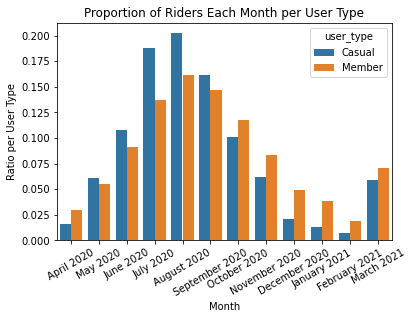

In [9]:
#Normalizing value counts so we can have ratios
temp_trips = (trips['month']
               .groupby(trips['user_type'])
               .value_counts(normalize=True)
               .rename('y')
               .reset_index())
month_order = ['April','May','June','July','August','September','October','November','December','January','February','March']

plt = sns.barplot(x='month',y='y', data=temp_trips, hue='user_type', order=month_order)
plt.set_title('Proportion of Riders Each Month per User Type')
plt.set_xlabel('Month')
plt.set_ylabel('Ratio per User Type')
plt.set_xticklabels(rotation=30, labels=['April 2020','May 2020','June 2020','July 2020','August 2020','September 2020','October 2020','November 2020','December 2020','January 2021','February 2021','March 2021'])
plt

Casual riders tend to use the service proportionally much more frequently during the spring and summer and less over the fall and winter, compared to members who have less of a stark difference between winter and summer.

**Proportion of riders each day of the week**

<AxesSubplot:title={'center':'Proportion of Riders Each Day of the Week per User Type'}, xlabel='Weekday', ylabel='Ratio per User Type'>

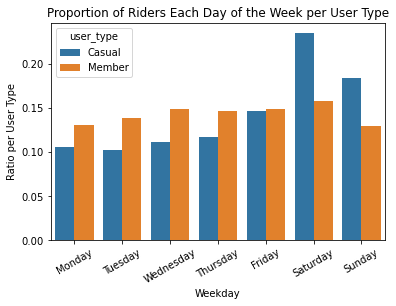

In [10]:
#Proportion of rider type each day of the week
temp_trips = (trips['weekday']
               .groupby(trips['user_type'])
               .value_counts(normalize=True)
               .rename('y')
               .reset_index())
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

plt = sns.barplot(x='weekday',y='y', data=temp_trips, hue='user_type', order=weekday_order)
plt.set_title('Proportion of Riders Each Day of the Week per User Type')
plt.set_xlabel('Weekday')
plt.set_ylabel('Ratio per User Type')
plt.set_xticklabels(plt.get_xticklabels(), rotation=30)
plt

Casual riders tend to use the service most frequently over the weekend (Saturday and Sunday), while members are more evenly distributed.

**Proportion of riders at each hour**

<AxesSubplot:title={'center':'Proportion of Riders at Each Hour per User Type'}, xlabel='Hour', ylabel='Ratio per User Type'>

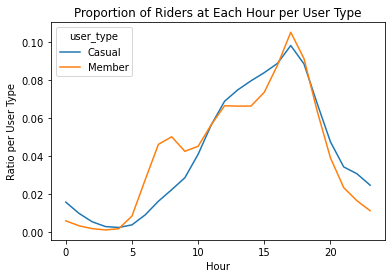

In [11]:
temp_trips = (trips['hour']
               .groupby(trips['user_type'])
               .value_counts(normalize=True)
               .rename('y')
               .reset_index())

plt = sns.lineplot(x='hour',y='y', data=temp_trips, hue='user_type')
plt.set_title('Proportion of Riders at Each Hour per User Type')
plt.set_xlabel('Hour')
plt.set_ylabel('Ratio per User Type')
plt

Members tend to use the service more frequently in the morning and early evening, compared to casual who are more evenly distributed. This suggest that casuals don't use the service as much to transit to work.

**Average duration of trips**

In [12]:
trips.groupby('user_type').mean()['duration']

user_type
Casual    44.969537
Member    16.115112
Name: duration, dtype: float64

Casuals tend to have much longer trips at an average of 45 minutes per trip compared to members who average at 16 minutes.

**Proportion of round trips**

In [13]:
trips.groupby('user_type').mean()['round_trip']

user_type
Casual    0.173540
Member    0.055679
Name: round_trip, dtype: float64

Casuals tend to do round trips much more frequently at 17% of the time compared to member who do round trips 6% of the time.

**Average distance travelled**

In [14]:
trips[trips['round_trip'] == 0].groupby('user_type').agg(['mean','std'])['distance']

,mean,std
user_type,,
Casual,2643.630490,2138.007018
Member,2398.904713,1899.685164


After removing round trips (of distance equal to 0), casual riders appear to travel slightly further distances by 250 meters, however this difference is not very significant enough to be notable.

**Type of bike preference**

In [15]:
gb = trips.groupby(['user_type','rideable_type']).count()['date']
gb.groupby(level=0).apply(lambda x: x/x.sum())

user_type  rideable_type
Casual     Classic          0.829788
           Electric         0.170212
Member     Classic          0.820531
           Electric         0.179469
Name: date, dtype: float64

There is no difference in the type of bike each user type prefer to use.

## Conclusion  
There seems to be no significant difference between the two types of users in the distance of the trip and in the type of bike preference. We can on the other hand observe from the above analysis the following difference:
- **Month**: Casual riders tend to use the service proportionally much more frequently during the spring and summer and less over the fall and winter, compared to members who have less of a stark difference between winter and summer.
- **Weekday**: Casual riders tend to use the service most frequently over the weekend (Saturday and Sunday), while members are more evenly distributed.
- **Hour**: Members tend to use the service more frequently in the morning and early evening, compared to casual who are more evenly distributed. This suggest that casuals don't use the service as much to transit to work.
- **Trip Duration**: Casuals tend to have much longer trips at an average of 45 minutes per trip compared to members who average at 16 minutes.
- **Round Trips**: Casuals tend to do round trips much more frequently at 17% of the time compared to member who do round trips 6% of the time.

Overall, these observatons suggest that casuals tend to use the service much more frequently for leisure (over the weekend, in the summer,etc), than members who perhaps use it as their main mode of transportation (for work, during the winter, etc).

A Tableau dashboard with the above findings can also be found at the following link:  
https://public.tableau.com/profile/michael2724#!/vizhome/Ride-ShareAnalysis/UserTypeComparison

**Potential improvements**  
Unfortunately, we don't have any information on users due to privacy issues. On a bigger project, we might want to analyse the behavior difference of casual riders and annual members such as knowing the frequency at which members and casuals use the service, or if there are any patterns in the way any of the two groups use the service, like using it for work or for leisure.